# Inference: U-Net notebook for Palaeochannels dataset
__Input of this notebook:__

- image_folder path
        
- mask_folder path

- checkpoint path

In [71]:
# SET working Directory of the code
import os
workdir = os.path.abspath(os.path.join(os.getcwd(), '..'))  # Set workdir to the parent directory (Paleo)

In [72]:
from dotenv import load_dotenv
load_dotenv()
from pathlib import Path
from segmentation_models_pytorch.decoders.unet import Unet
from torchinfo import summary

import sys
sys.path.append(str(workdir))

from esa_cls_palaeo.dataset import SingleRasterPalaeochannelDataset
import geopandas as gpd
from tqdm import tqdm
from torch.utils.data import DataLoader, ConcatDataset
import kornia.augmentation as K

from typing import Any
from lightning.pytorch.utilities.types import STEP_OUTPUT
import torch
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import segmentation_models_pytorch as smp
import os
from lightning.pytorch.loggers import TensorBoardLogger

from lightning.pytorch import LightningModule
from segmentation_models_pytorch.decoders.unet import Unet
from torchgeo.models.resnet import ResNet50_Weights, resnet50
import torchvision.models as models
from torchmetrics.classification import BinaryJaccardIndex, BinaryPrecision, BinaryRecall, BinaryPrecisionRecallCurve

from torchvision.utils import make_grid, draw_segmentation_masks
from PIL import Image


In [73]:
import rasterio as rio
import matplotlib.pyplot as plt
from rasterio.plot import reshape_as_image
from torch.masked import masked_tensor
import torch.nn.functional as F
import numpy as np
from rasterio.transform import from_origin
from pathlib import Path

In [74]:
#### SET variables
# Path_to_folder_images
images_path = "/HDD1/data_paleo/Images/"

month= "05_2023/" # change 

test_img_folder = Path(images_path + month + "output_raster_tiles")
test_mask_folder = Path(images_path + month + "output_mask_tiles")

print(test_img_folder)
print(test_mask_folder)

# set output path 
save_output = True

output_path = Path(images_path + month + "Unet_inference_tiles")
if not os.path.exists(output_path):
    os.makedirs(output_path)

/HDD1/data_paleo/Images/05_2023/output_raster_tiles
/HDD1/data_paleo/Images/05_2023/output_mask_tiles


In [75]:
# checkpoint path
chkp= "/HDD1/data_paleo/checkpoints/Unet/checkpoint_unet_2month/epoch=16-val_iou=0.20449208.ckpt"

# LightningModule

In [76]:
# Loading the model
model = Unet(encoder_name='resnet50', in_channels=3)
summary(model.encoder, input_size=(32, 3, 256, 256))

Layer (type:depth-idx)                   Output Shape              Param #
ResNetEncoder                            [32, 3, 256, 256]         --
├─Conv2d: 1-1                            [32, 64, 128, 128]        9,408
├─BatchNorm2d: 1-2                       [32, 64, 128, 128]        128
├─ReLU: 1-3                              [32, 64, 128, 128]        --
├─MaxPool2d: 1-4                         [32, 64, 64, 64]          --
├─Sequential: 1-5                        [32, 256, 64, 64]         --
│    └─Bottleneck: 2-1                   [32, 256, 64, 64]         --
│    │    └─Conv2d: 3-1                  [32, 64, 64, 64]          4,096
│    │    └─BatchNorm2d: 3-2             [32, 64, 64, 64]          128
│    │    └─ReLU: 3-3                    [32, 64, 64, 64]          --
│    │    └─Conv2d: 3-4                  [32, 64, 64, 64]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 64, 64]          128
│    │    └─ReLU: 3-6                    [32, 64, 64, 64]          --
│ 

In [77]:
from typing import Sequence
from lightning.pytorch.callbacks.callback import Callback
from lightning.pytorch.utilities.types import OptimizerLRScheduler
from lightning.pytorch.callbacks import StochasticWeightAveraging

class PalaeochannelRGBExperimentModule(LightningModule):
    def __init__(self, *args: Any, 
                 learning_rate: float = 1.0e-3, 
                 logits_threshold: float = 0.1, 
                 weight_decay: float = 1.0e-3, 
                 clip_stds: float = 2.5, 
                 swa_lrs = 1e-3,
                 swa_epoch_start = 20,
                 tversky_gamma: float = 1.0, 
                 tversky_alpha: float = 0.4, 
                 tversky_beta: float = 0.6,
                 model_tag: str = 'unet-resnet50-sen2-rgb-moco', # Consider a smarter tagging strategy.
                 **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)
        self.save_hyperparameters()
        
        # Model creation and weights loading
        if model_tag == 'unet-resnet50-sen2-rgb-moco':
            self.model = Unet(encoder_name="resnet50", in_channels=3)
            encoder_model = resnet50(weights=ResNet50_Weights.SENTINEL2_RGB_MOCO)
            self.model.encoder.load_state_dict(encoder_model.state_dict())
        else:
            self.model = Unet(encoder_name="mit_b5", decoder_attention_type='scse', in_channels=3)
        
        # Loss function
        # self.loss_criterion = smp.losses.TverskyLoss(mode="binary", 
        #                                              gamma=self.hparams.tversky_gamma, 
        #                                              alpha=self.hparams.tversky_alpha, 
        #                                              beta=self.hparams.tversky_beta,)
            
        self.loss_criterion = smp.losses.DiceLoss(mode='binary')
        # Augmentations
        self.spatial_augmentation_pipeline = K.AugmentationSequential(
            K.RandomHorizontalFlip(p=0.5),
            K.RandomVerticalFlip(p=0.5),
            data_keys=["input", "mask"]  # Apply to both image and mask
        )
        self.color_augmentation_pipeline = K.AugmentationSequential(
            # K.ColorJitter(brightness=0.2, contrast=0.3, saturation=0.2, hue=0.1),
            data_keys=["input"]  # Apply to images only
        )
        # Metrics creation
        self.train_iou = BinaryJaccardIndex(threshold=self.hparams.logits_threshold)
        self.train_precision = BinaryPrecision(threshold=self.hparams.logits_threshold)
        self.train_recall = BinaryRecall(threshold=self.hparams.logits_threshold)
        
        self.validation_iou = BinaryJaccardIndex(threshold=self.hparams.logits_threshold)
        self.validation_precision = BinaryPrecision(threshold=self.hparams.logits_threshold)
        self.validation_recall = BinaryRecall(threshold=self.hparams.logits_threshold)
        
        self.validation_prec_rec_curve = BinaryPrecisionRecallCurve(thresholds=20)
        
        
        
    def configure_callbacks(self) -> Sequence[Callback] | Callback:
        swa = StochasticWeightAveraging(swa_lrs=self.hparams.swa_lrs, 
                                        swa_epoch_start=self.hparams.swa_epoch_start)
        return [swa]
    
    def configure_optimizers(self) -> OptimizerLRScheduler:
        return optim.Adam(self.model.parameters(),
                          lr=self.hparams.learning_rate, 
                          weight_decay=self.hparams.weight_decay)

    def on_after_batch_transfer(self, batch: Any, dataloader_idx: int) -> Any:
        # Fix batch types.
        images = batch['image'].float()
        masks = batch['mask'].float().unsqueeze(1)
        
        # Finish raster to tensor conversion
        images = torch.movedim(images, -1, -3)
        images = images[:, [3, 2, 1], :, :] # Select RGB bands
         
        # Clip each tile bands using local statistics.
        from torch.masked import masked_tensor
        masked_images = masked_tensor(images, images > 0.0)
        images_mean = masked_images.mean(dim=(2, 3), keepdim=True).get_data()
        images_std = masked_images.std(dim=(2, 3), keepdim=True).get_data()
        images_max_clip = images_mean + self.hparams.clip_stds * images_std
        images_min_clip = images_mean - self.hparams.clip_stds * images_std
        images = (images - images_min_clip) / (images_max_clip - images_min_clip)
        
        # Data augmentation during training.
        if self.trainer.training: 
            images = self.color_augmentation_pipeline(images)
            images, masks = self.spatial_augmentation_pipeline(images, masks)
        
        batch['image'] = images
        batch['mask'] = masks.squeeze(1).int()
        return super().on_after_batch_transfer(batch, dataloader_idx)
    
    def forward(self, batch):
        x = batch['image']
        # Do not propagate gradient to the encoder network for now.
        with torch.no_grad():
            features = self.model.encoder(x)
        decoder_output = self.model.decoder(*features)

        return self.model.segmentation_head(decoder_output)
    
    def training_step(self, batch, batch_idx, *args: Any, **kwargs: Any) -> STEP_OUTPUT:
        logits = self.forward(batch).squeeze()
        loss = self.loss_criterion(logits, batch['mask'])
        
        # Update metrics
        self.train_iou(logits, batch['mask'])
        self.train_precision(logits, batch['mask'])
        self.train_recall(logits, batch['mask'])
        
        # Log step loss
        batch_size = batch['image'].shape[0]
        self.log('train/loss', loss, on_epoch=True, on_step=True, batch_size=batch_size)
        
        # Log batch output (images)
        if batch_idx == 0:
            self.log_batch_output(batch, logits)
            
        return loss
    
    def on_train_epoch_end(self) -> None:
        # Log metrics
        self.log('train/iou', self.train_iou)
        self.log('train/precision', self.train_precision)
        self.log('train/recall', self.train_recall)
        return super().on_train_epoch_end()
    
    def log_batch_output(self, batch, logits):
        if isinstance(self.logger, TensorBoardLogger):
            stage = 'none'
            if self.trainer.validating:
                stage = 'validation'
            if self.trainer.training:
                stage = 'train'
            mask = batch['mask'].unsqueeze(1)
            segmentation_mask = logits.unsqueeze(1) > self.hparams.logits_threshold
            summary_writer: SummaryWriter = self.logger.experiment
            summary_writer.add_images(f'{stage}/image', batch['image'], global_step=self.trainer.global_step)
            summary_writer.add_images(f'{stage}/mask', mask * 255, global_step=self.trainer.global_step)
            summary_writer.add_images(f'{stage}/logits', segmentation_mask, global_step=self.trainer.global_step)
            
            
    # The same thing as the training step but on validation objects.
    def validation_step(self, batch, batch_idx, *args: Any, **kwargs: Any) -> STEP_OUTPUT:
        logits = self.forward(batch).squeeze()
        loss = self.loss_criterion(logits, batch['mask'])
        
        self.validation_iou(logits, batch['mask'])
        self.validation_precision(logits, batch['mask'])
        self.validation_recall(logits, batch['mask'])
        
        self.validation_prec_rec_curve(logits, batch['mask'])
        
        batch_size = batch['image'].shape[0]
        self.log('validation/loss', loss, on_epoch=True, batch_size=batch_size)
        if batch_idx == 0:
            self.log_batch_output(batch, logits)
        
        return loss
        
    def on_validation_epoch_end(self) -> None:
        self.log('validation/iou', self.validation_iou)
        self.log('validation/precision', self.validation_precision)
        self.log('validation/recall', self.validation_recall)
        
        # Log the precision recall curve!
        if isinstance(self.logger, TensorBoardLogger):
            summary_writer: SummaryWriter = self.logger.experiment
            fig_, ax_ = self.validation_prec_rec_curve.plot(score=True)
            summary_writer.add_figure('validation/prec_rec_curve', figure=fig_, global_step=self.trainer.global_step)
            
        return super().on_validation_epoch_end()

# Inference

In [78]:
# load the model
model= PalaeochannelRGBExperimentModule.load_from_checkpoint(chkp)

model.eval()

PalaeochannelRGBExperimentModule(
  (model): Unet(
    (encoder): MixVisionTransformerEncoder(
      (patch_embed1): OverlapPatchEmbed(
        (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
        (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
      )
      (patch_embed2): OverlapPatchEmbed(
        (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
      (patch_embed3): OverlapPatchEmbed(
        (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
      )
      (patch_embed4): OverlapPatchEmbed(
        (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      )
      (block1): ModuleList(
        (0): Block(
          (norm1): LayerNorm((64,), eps=1e-06, ele

In [79]:
# show the result
def show_image_mask (image1,image2,image3):
    # Create a figure and axes objects with 1 row and 3 columns
    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    # Plot the first RGB image on the first subplot
    image1 = reshape_as_image(image1)
    axes[0].imshow(image1)
    axes[0].set_title('Image')

    # Plot the second binary image on the second subplot
    image2 = reshape_as_image(image2)
    axes[1].imshow(image2, cmap='gray')
    axes[1].set_title('Mask')

    # Plot the third binary image on the third subplot
    axes[2].imshow(image3, cmap='gray')
    axes[2].set_title('result')

    image2=image2.squeeze()
    

    overlay_img= np.zeros((image2.shape[0], image2.shape[1], 3), dtype=np.uint8)
    print('overlay',overlay_img.shape)
    overlay_img[:,:,0]=image3*255 # put the result on red
    overlay_img[:,:,1]=image2*255 # put the mask on green
    print('min,max',overlay_img.min(),overlay_img.max())

    # Plot the overlay_img
    axes[3].imshow(overlay_img)
    axes[3].set_title('overlay')


    # Hide the axis ticks for all subplots
    for ax in axes:
        ax.set_xticks([])
        ax.set_yticks([])

    # Display the plot
    plt.show()

In [80]:
def calculate_metrics(binary_image, mask): 
    # Calculate True Positives, False Positives, False Negatives
    true_positives = np.logical_and(binary_image, mask).sum()
    false_positives = np.logical_and(binary_image, np.logical_not(mask)).sum()
    false_negatives = np.logical_and(np.logical_not(binary_image), mask).sum()

    # Calculate Intersection over Union (IoU)
    intersection = true_positives
    union = true_positives + false_positives + false_negatives
    iou = intersection / union if union > 0 else 0.0

    # Calculate Recall
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0
    
    # Calculate Precision
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
    print('fp', false_positives,'fn',false_negatives)

    # Calculate F1
    f1 = 2*(precision*recall)/(precision+recall) if recall > 0 else 0.0
    return iou, recall, precision, f1

In [81]:
def save_binary_image(binary_image, output_path, filename, mask_file_path):
    """
    Saves a binary image as a georeferenced raster, taking georeferencing information from the mask file.
    
    Args:
        binary_image (np.array): Binary image array (0 and 1 values).
        output_path (str): Directory to save the output raster.
        filename (str): Name of the output file.
        mask_file_path (str): Path to the mask file used for georeferencing.
    """

    # Convert the binary image array to uint8
    binary_image_uint8 = (binary_image * 255).astype(np.uint8)

    # Ensure the output directory exists
    output_dir = Path(output_path)
    output_dir.mkdir(parents=True, exist_ok=True)

    # Construct the full file path
    file_path = output_dir / filename

    # Open the original georeferenced image using Rasterio
    with rio.open(mask_file_path) as mask_dataset:
        if mask_dataset is None:
            raise ValueError(f"Could not open {mask_file_path} for georeferencing information.")

        # Retrieve geotransform and projection from the mask image
        geotransform = mask_dataset.transform
        projection = mask_dataset.crs

    # Get image dimensions from the binary image
    height, width = binary_image.shape

    # Create a new georeferenced raster file
    with rio.open(str(file_path), 'w', driver='GTiff', count=1, dtype='uint8', 
                       width=width, height=height, crs=projection, transform=geotransform, nodata=0) as output_dataset:
        # Write the binary image to the new raster
        output_dataset.write(binary_image_uint8, 1)
        

    print(f"Saved georeferenced binary image: {file_path}")


In [82]:
def print_output (test_img,test_mask):
    with rio.open(test_img) as src:
        # Read the image as a numpy array
        image = src.read()
        # profile = src.profile
        # crs = src.crs
        # transform = src.transform

    with rio.open(test_mask) as src:
    # Read the image as a numpy array
        mask = src.read()
        # profile = src.profile
        # crs = src.crs
        # transform = src.transform

    #normalization
    clip_stds =2.5
    image_mean = image.mean()
    image_std = image.std()
    image_max_clip = image_mean + clip_stds * image_std
    image_min_clip = image_mean - clip_stds * image_std
    test_image = (image - image_min_clip) / (image_max_clip - image_min_clip) #[0,1]

    # change to tensor
    tile_image_tensor = torch.from_numpy(test_image)
    # set device
    tile_image_test = tile_image_tensor.to(0)
    tile_image_test = tile_image_test.float()

    # get prediction
    output= model(dict(image=tile_image_test.unsqueeze(0)))
    
    # activate function
    output = F.sigmoid(output)
    # Convert the tensor to a NumPy array and remove the batch dimension
    image_array = output.squeeze().cpu().detach().numpy()
    binary_image = (image_array > 0.5).astype(int)
    # Plot the binary image using matplotlib
    # plt.imshow(binary_image, cmap='binary')  # 'binary' colormap for binary images
    # plt.show()
    show_image_mask(image,mask,binary_image)

   # Calculate metrics
    iou, recall, precision, f1 = calculate_metrics(binary_image, mask)


    print("IoU:", iou)
    print("Recall:", recall)
    print("Precision:", precision)
    print("f1:", f1)


    return iou, recall, precision,f1, binary_image

overlay (256, 256, 3)
min,max 0 255


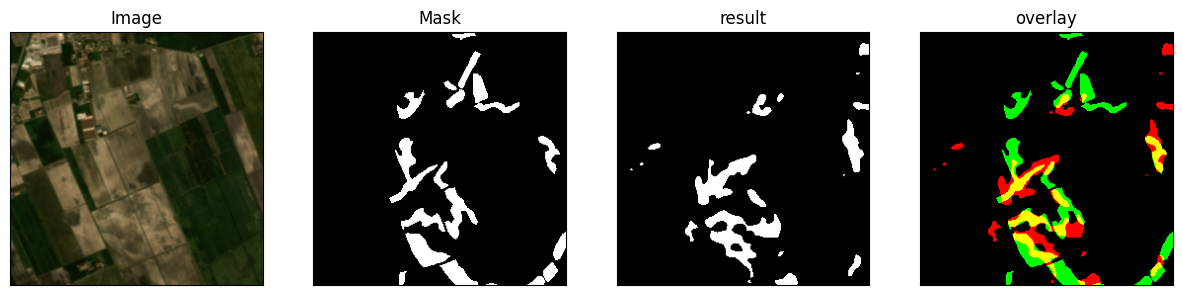

fp 2444 fn 3663
IoU: 0.26642642642642644
Recall: 0.3771467437510627
Precision: 0.47576147576147576
f1: 0.4207531063264725
Image File Path: /HDD1/data_paleo/Images/05_2023/output_raster_tiles/raster_tile_0.tif
Mask File Path: /HDD1/data_paleo/Images/05_2023/output_mask_tiles/mask_tile_0.tif
iou 0.26642642642642644
recall 0.3771467437510627
precision 0.47576147576147576
f1 0.4207531063264725
Saved georeferenced binary image: /HDD1/data_paleo/Images/05_2023/Unet_inference_tiles/result_raster_tile_0.tif
overlay (256, 256, 3)
min,max 0 255


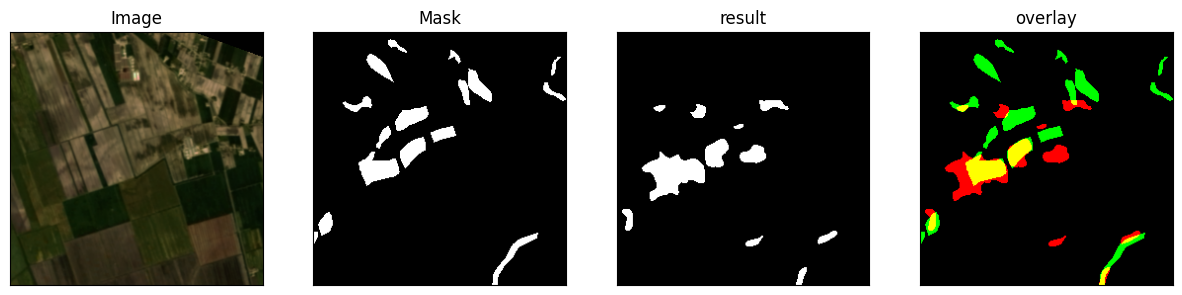

fp 2002 fn 2818
IoU: 0.2422575066813394
Recall: 0.3535214498738243
Precision: 0.4349421394298617
f1: 0.39002784105289795
Image File Path: /HDD1/data_paleo/Images/05_2023/output_raster_tiles/raster_tile_1.tif
Mask File Path: /HDD1/data_paleo/Images/05_2023/output_mask_tiles/mask_tile_1.tif
iou 0.2422575066813394
recall 0.3535214498738243
precision 0.4349421394298617
f1 0.39002784105289795
Saved georeferenced binary image: /HDD1/data_paleo/Images/05_2023/Unet_inference_tiles/result_raster_tile_1.tif
overlay (256, 256, 3)
min,max 0 255


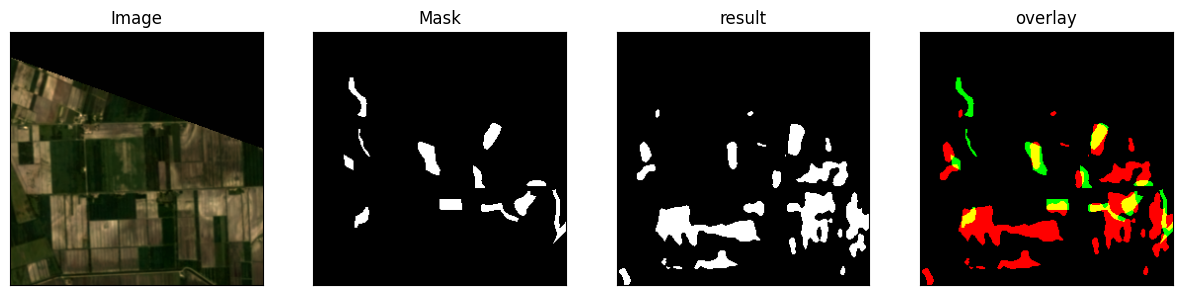

fp 5596 fn 1181
IoU: 0.17009551800146952
Recall: 0.5404669260700389
Precision: 0.19885468861846814
f1: 0.29073783359497646
Image File Path: /HDD1/data_paleo/Images/05_2023/output_raster_tiles/raster_tile_2.tif
Mask File Path: /HDD1/data_paleo/Images/05_2023/output_mask_tiles/mask_tile_2.tif
iou 0.17009551800146952
recall 0.5404669260700389
precision 0.19885468861846814
f1 0.29073783359497646
Saved georeferenced binary image: /HDD1/data_paleo/Images/05_2023/Unet_inference_tiles/result_raster_tile_2.tif
overlay (256, 256, 3)
min,max 0 255


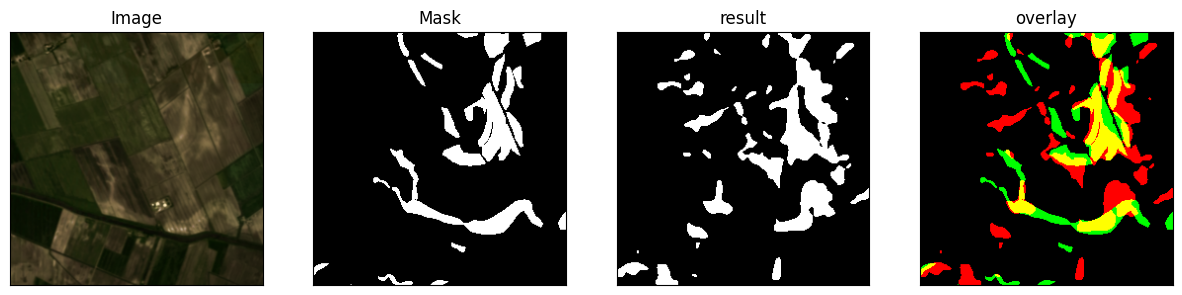

fp 5454 fn 3509
IoU: 0.3088371375694016
Recall: 0.5330050572265105
Precision: 0.4234062797335871
f1: 0.4719260001178342
Image File Path: /HDD1/data_paleo/Images/05_2023/output_raster_tiles/raster_tile_3.tif
Mask File Path: /HDD1/data_paleo/Images/05_2023/output_mask_tiles/mask_tile_3.tif
iou 0.3088371375694016
recall 0.5330050572265105
precision 0.4234062797335871
f1 0.4719260001178342
Saved georeferenced binary image: /HDD1/data_paleo/Images/05_2023/Unet_inference_tiles/result_raster_tile_3.tif
overlay (256, 256, 3)
min,max 0 255


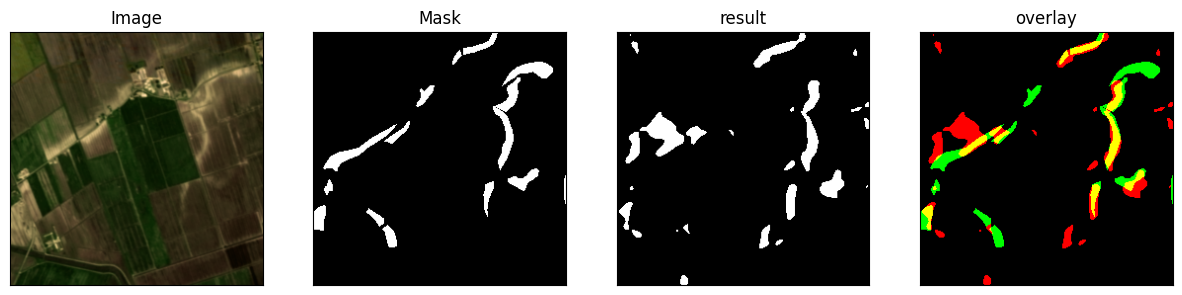

fp 2501 fn 2115
IoU: 0.27501177948798494
Recall: 0.4529229177444387
Precision: 0.4118062088428975
f1: 0.4313870411431387
Image File Path: /HDD1/data_paleo/Images/05_2023/output_raster_tiles/raster_tile_4.tif
Mask File Path: /HDD1/data_paleo/Images/05_2023/output_mask_tiles/mask_tile_4.tif
iou 0.27501177948798494
recall 0.4529229177444387
precision 0.4118062088428975
f1 0.4313870411431387
Saved georeferenced binary image: /HDD1/data_paleo/Images/05_2023/Unet_inference_tiles/result_raster_tile_4.tif
overlay (256, 256, 3)
min,max 0 255


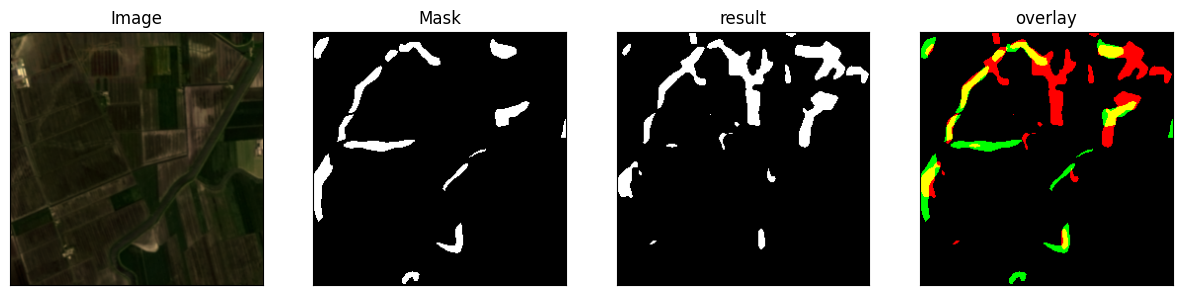

fp 3568 fn 1860
IoU: 0.2576586433260394
Recall: 0.5032051282051282
Precision: 0.34556126192223036
f1: 0.4097433666811657
Image File Path: /HDD1/data_paleo/Images/05_2023/output_raster_tiles/raster_tile_5.tif
Mask File Path: /HDD1/data_paleo/Images/05_2023/output_mask_tiles/mask_tile_5.tif
iou 0.2576586433260394
recall 0.5032051282051282
precision 0.34556126192223036
f1 0.4097433666811657
Saved georeferenced binary image: /HDD1/data_paleo/Images/05_2023/Unet_inference_tiles/result_raster_tile_5.tif
overlay (256, 256, 3)
min,max 0 255


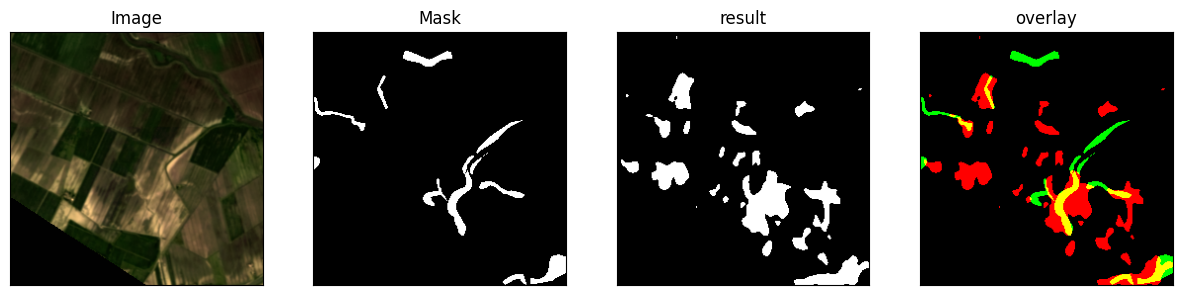

fp 5081 fn 1395
IoU: 0.1774418900038105
Recall: 0.5003581661891118
Precision: 0.21565297931460328
f1: 0.3014023732470335
Image File Path: /HDD1/data_paleo/Images/05_2023/output_raster_tiles/raster_tile_6.tif
Mask File Path: /HDD1/data_paleo/Images/05_2023/output_mask_tiles/mask_tile_6.tif
iou 0.1774418900038105
recall 0.5003581661891118
precision 0.21565297931460328
f1 0.3014023732470335
Saved georeferenced binary image: /HDD1/data_paleo/Images/05_2023/Unet_inference_tiles/result_raster_tile_6.tif
overlay (256, 256, 3)
min,max 0 255


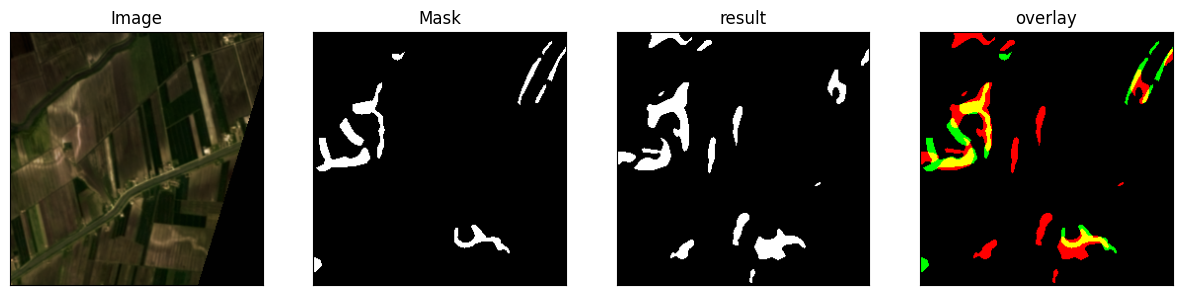

fp 3014 fn 1155
IoU: 0.26225446823571047
Recall: 0.5620022753128555
Precision: 0.32962633451957296
f1: 0.4155334361418758
Image File Path: /HDD1/data_paleo/Images/05_2023/output_raster_tiles/raster_tile_7.tif
Mask File Path: /HDD1/data_paleo/Images/05_2023/output_mask_tiles/mask_tile_7.tif
iou 0.26225446823571047
recall 0.5620022753128555
precision 0.32962633451957296
f1 0.4155334361418758
Saved georeferenced binary image: /HDD1/data_paleo/Images/05_2023/Unet_inference_tiles/result_raster_tile_7.tif
Average IoU: 0.24499792121652278
Average Recall: 0.47782858304662135
Average Precision: 0.3544514210178371
Average F1: 0.3914388747881744
Results saved to /HDD1/data_paleo/Images/05_2023/results_summary.txt


In [83]:
# Get a list of all files in the image folder
img_file_names = sorted(os.listdir(test_img_folder))

# Get a list of all files in the mask folder
mask_file_names = sorted(os.listdir(test_mask_folder))

iou_total, recall_total, precision_total, f1_total = 0.0, 0.0, 0.0, 0.0

# Use zip to iterate over both lists simultaneously
for img_file_name, mask_file_name in zip(img_file_names, mask_file_names):
    img_file_path = os.path.join(test_img_folder, img_file_name)
    mask_file_path = os.path.join(test_mask_folder, mask_file_name)
    
    # Calculate metrics for the current pair of images
    iou, recall, precision, f1, binary_image = print_output(img_file_path, mask_file_path)
    
    # Accumulate metrics
    iou_total += iou
    recall_total += recall
    precision_total += precision
    f1_total+=f1
    
    print("Image File Path:", img_file_path)
    print("Mask File Path:", mask_file_path)
    print('iou', iou)
    print('recall', recall)
    print('precision', precision)
    print('f1', f1)

    # Save output using georeferencing from the mask
    if save_output:
        filename = 'result_' + img_file_name
        save_binary_image(binary_image, output_path, filename, mask_file_path)
      


# Calculate averages
num_files = len(img_file_names)
average_iou = iou_total / num_files
average_recall = recall_total / num_files
average_precision = precision_total / num_files
average_f1= f1_total/num_files

print('Average IoU:', average_iou)
print('Average Recall:', average_recall)
print('Average Precision:', average_precision)
print('Average F1:', average_f1)

# Format the results into a string
results_content = f"""Results Summary:
---------------------
Average IoU: {average_iou}
Average Recall: {average_recall}
Average Precision: {average_precision}
Average F1:{average_f1}
"""

# Save to a text file
results_file_path = images_path + month + "results_summary.txt"

with open(results_file_path, "w") as results_file:
    results_file.write(results_content)

print(f"Results saved to {results_file_path}")


-------------------------------------------------------